Generación 1


C:\Users\esco1\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cromosoma: {'learning_rate': 0.05, 'batch_size': 64, 'num_filters': 16, 'dense_units': 120, 'activation': 'tanh', 'optimizer': 'sgd'}, Fitness: 0.9778000116348267
El mejor modelo con fitness 0.9778000116348267
Cromosoma: {'learning_rate': 0.1, 'batch_size': 64, 'num_filters': 6, 'dense_units': 120, 'activation': 'relu', 'optimizer': 'adam'}, Fitness: 0.10599999874830246
Cromosoma: {'learning_rate': 0.05, 'batch_size': 64, 'num_filters': 16, 'dense_units': 120, 'activation': 'relu', 'optimizer': 'sgd'}, Fitness: 0.9742000102996826
Cromosoma: {'learning_rate': 0.1, 'batch_size': 32, 'num_filters': 6, 'dense_units': 120, 'activation': 'relu', 'optimizer': 'adam'}, Fitness: 0.10599999874830246
Cromosoma: {'learning_rate': 0.1, 'batch_size': 32, 'num_filters': 6, 'dense_units': 84, 'activation': 'relu', 'optimizer': 'adam'}, Fitness: 0.09880000352859497
Cromosoma: {'learning_rate': 0.05, 'batch_size': 32, 'num_filters': 16, 'dense_units': 84, 'activation': 'tanh', 'optimizer': 'sgd'}, Fitne

Cromosoma: {'learning_rate': 0.05, 'batch_size': 64, 'num_filters': 16, 'dense_units': 120, 'activation': 'tanh', 'optimizer': 'sgd'}, Fitness: 0.9801999926567078
Cromosoma: {'learning_rate': 0.05, 'batch_size': 32, 'num_filters': 16, 'dense_units': 84, 'activation': 'tanh', 'optimizer': 'sgd'}, Fitness: 0.9814000129699707
Cromosoma: {'learning_rate': 0.05, 'batch_size': 32, 'num_filters': 16, 'dense_units': 120, 'activation': 'tanh', 'optimizer': 'sgd'}, Fitness: 0.9818000197410583
El mejor fitness en la generación 5: 0.9837999939918518


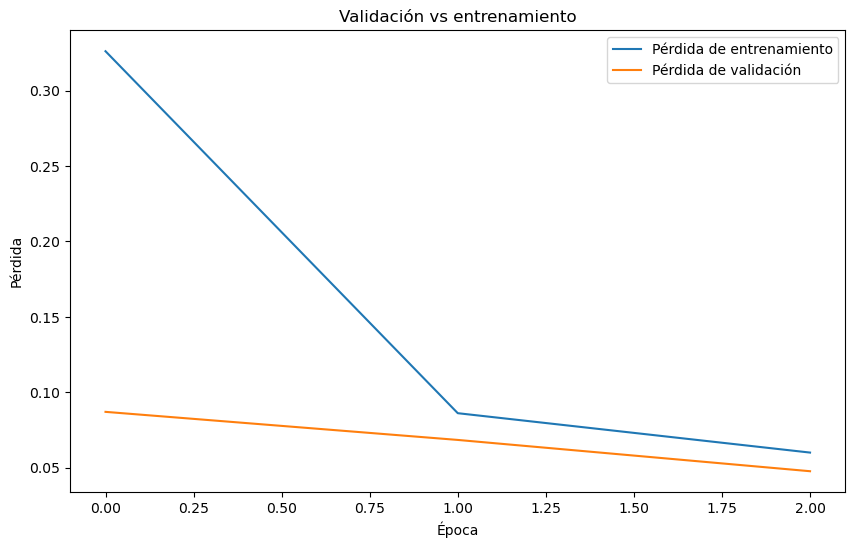

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


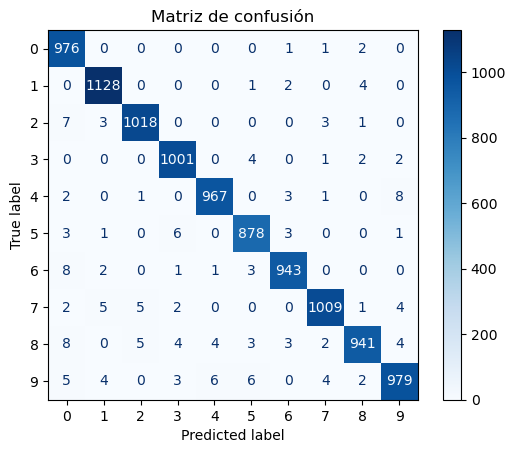

Mejor modelo: 'mejor_modelomnist.h5'
Los mejores hiperparámetros: {'learning_rate': 0.05, 'batch_size': 32, 'num_filters': 16, 'dense_units': 84, 'activation': 'relu', 'optimizer': 'sgd'}
El mejor fitness: 0.9860000014305115


In [4]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_val, y_val = X_train[55000:], y_train[55000:]
X_train, y_train = X_train[:55000], y_train[:55000]


X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_val = np.pad(X_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')


X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'batch_size': [32, 64, 128],
    'num_filters': [6, 16],
    'dense_units': [84, 120],
    'activation': ['relu', 'tanh'],
    'optimizer': ['sgd', 'adam']
}

def create_chromosome():
    return {
        'learning_rate': random.choice(param_grid['learning_rate']),
        'batch_size': random.choice(param_grid['batch_size']),
        'num_filters': random.choice(param_grid['num_filters']),
        'dense_units': random.choice(param_grid['dense_units']),
        'activation': random.choice(param_grid['activation']),
        'optimizer': random.choice(param_grid['optimizer'])
    }

def create_population(size):
    return [create_chromosome() for _ in range(size)]

def fitness(chromosome):
    
    model = Sequential([
        Conv2D(chromosome['num_filters'], kernel_size=5, activation=chromosome['activation'], input_shape=(32,32,1)),
        AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
        Conv2D(chromosome['num_filters'] * 2, kernel_size=5, activation=chromosome['activation']),
        AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
        Flatten(),
        Dense(chromosome['dense_units'], activation=chromosome['activation']),
        Dense(chromosome['dense_units'] // 2, activation=chromosome['activation']),
        Dense(10, activation='softmax')
    ])

    
    optimizer = tf.keras.optimizers.SGD(chromosome['learning_rate']) if chromosome['optimizer'] == 'sgd' else tf.keras.optimizers.Adam(chromosome['learning_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    
    history = model.fit(X_train, y_train, epochs=3, batch_size=chromosome['batch_size'], validation_data=(X_val, y_val), verbose=0)

    
    return history.history['val_accuracy'][-1], history.history, model

def select_parents(population, fitnesses, num_parents):
    parents = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
    return parents[:num_parents]

def crossover(parent1, parent2):
    child = {}
    for param in param_grid.keys():
        child[param] = random.choice([parent1[param], parent2[param]])
    return child

def mutate(chromosome, mutation_rate=0.1):
    if random.random() < mutation_rate:
        param = random.choice(list(param_grid.keys()))
        chromosome[param] = random.choice(param_grid[param])
    return chromosome

def genetic_algorithm(pop_size, num_generations):
    population = create_population(pop_size)
    best_model = None
    best_fitness = 0
    best_chromosome = None
    best_history = None  

    for generation in range(num_generations):
        print(f"Generación {generation+1}")

        
        fitnesses = []
        for chromosome in population:
            val_accuracy, history, model = fitness(chromosome)
            fitnesses.append(val_accuracy)
            print(f"Cromosoma: {chromosome}, Fitness: {val_accuracy}")

            if val_accuracy > best_fitness:
                best_fitness = val_accuracy
                best_model = model  # Mejor modelo
                best_chromosome = chromosome
                best_history = history 
                print(f"El mejor modelo con fitness {best_fitness}")

        print(f"El mejor fitness en la generación {generation+1}: {max(fitnesses)}")

        
        num_parents = pop_size // 2
        parents = select_parents(population, fitnesses, num_parents)

        
        next_generation = parents.copy()

        while len(next_generation) < pop_size:
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            child = mutate(child)
            next_generation.append(child)

        population = next_generation

    # Overfitting
    if best_history is not None:
        plot_overfitting(best_history)
    else:
        print("No se encontró un mejor historial para trazar.")

    if best_model is not None:
        plot_confusion_matrix(best_model, X_test, y_test)
        best_model.save('mejor_modelomnist.h5')
        print("Mejor modelo: 'mejor_modelomnist.h5'")

    print("Los mejores hiperparámetros:", best_chromosome)
    print(f"El mejor fitness: {best_fitness}")
    return best_chromosome, best_model

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test  
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriz de confusión')
    plt.show()

def plot_overfitting(history):
    train_loss = history['loss']
    val_loss = history['val_loss']

    
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label='Pérdida de entrenamiento')
    plt.plot(val_loss, label='Pérdida de validación')
    plt.title('Validación vs entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

best_hyperparameters, best_model = genetic_algorithm(pop_size=10, num_generations=5)
